In [3]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

B2.1a

In [4]:
#set randan seed
torch.manual_seed(200205854)
#set batch size
batchSize = 4
#set transfrom
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5])])

#Load the training data
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=False, num_workers=2)
#Load the test data
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, 
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
print('Training set size:', len(trainset))
print('Test set size:',len(testset))

Training set size: 60000
Test set size: 10000


Ankle boot T-shirt/top T-shirt/top      Dress


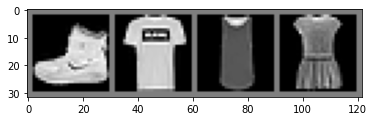

In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),cmap="gray") #rearrange dimensions to numpy format for disply
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next() #Get one batch (4 here)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(batchSize)))

B2.2b

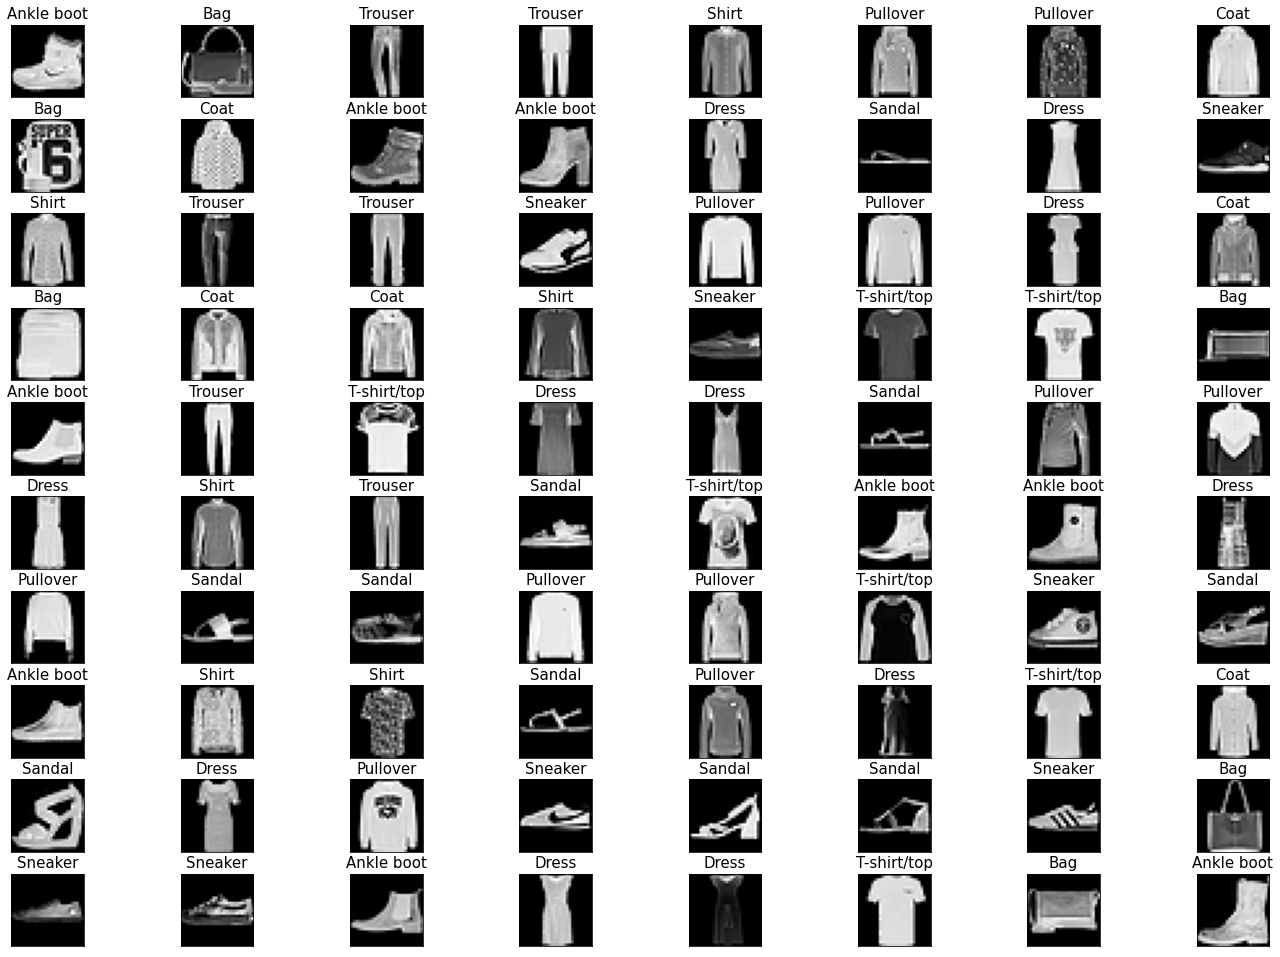

In [6]:
dataloader = torch.utils.data.DataLoader(trainset, batch_size=int(60000/80),
                                          shuffle=False, num_workers=2)
plt.subplots_adjust(left=0.5,
                    bottom=0.4, 
                    right=3.6, 
                    top=3.6, 
                    wspace=0.1, 
                    hspace=0.3)
def matplotlib_multi_pic1():
    i = 0
    for image, label in dataloader:
        i = i+1
        img = image[0]
        title=classes[label[0]]
        plt.subplot(10,8,i)
        imshow(img)
        plt.title(title,fontsize=15)
        plt.xticks([])
        plt.yticks([])
    plt.show()
matplotlib_multi_pic1()

In [7]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.lr = nn.Linear(28*28,10)
        self.sm = nn.Sigmoid()
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.lr(x)
        x = self.sm(x)
        return x

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(lr.parameters(), lr=0.005)

In [8]:
def train_lr_model(lr,b):
    max_epochs = 6
    #torch.cuda.synchronize()
    start = time.time()
    for epoch in range(max_epochs):
        running_loss = 0.0
        for i,(images, labels) in enumerate(trainloader):
            images = images
            labels = labels
            
            lr.zero_grad()
        
            output = criterion(lr(images), labels)
            l1_regularization, l2_regularization = torch.tensor([0], dtype=torch.float32), torch.tensor([0],dtype=torch.float32)  # 定义L1及L2正则化损失
            if(b == 'l1'):
                for param in lr.parameters():
                    l2_regularization += torch.norm(param,1)  # L2 正则化
                output = output + 10e-5 * l1_regularization
            elif(b == 'l2'):
                for param in lr.parameters():
                    l2_regularization += torch.norm(param,2)  # L2 正则化
                output = output + 10e-3 * l2_regularization
            elif(b == "n"):
                outpur = output
            loss =output.item()
        
            output.backward()
        
            # Apply gradients
            for param in lr.parameters():
                param.data.add_(-0.5 * param.grad.data)

            # Stop criterion
            if loss < 1e-3:
                break
            running_loss += loss
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    #torch.cuda.synchronize()
    end = time.time()
    print('training time %.2f' % (end-start))
    num_params = sum(x.numel() for x in lr.parameters())
    print("Total number of paramerters in LogristicRegression is {}".format(num_params))
    return (end-start), num_params

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    plt.title('confusion matrix', fontsize = 20)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=0.5,  cbar=True, ax=ax, cmap='Blues',square=True)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [12]:
# test the model
def test_model(model):
    correct = 0
    total = 0
    y_pred = []
    y = []
    for images, labels in trainloader:
        images= images
        labels =labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy_in_trainset = (100 * correct / total)
    print('accuracy of the model on training dataset %.2f' % accuracy_in_trainset)
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted
        y += labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy_in_testset = (100 * correct / total)
    print('accuracy of the model on test dataset %.2f' % (100 * correct / total))
    plot_confusion_matrix(y_pred, y)
    return accuracy_in_trainset, accuracy_in_testset
    

[1,  2000] loss: 1.700951
[1,  4000] loss: 1.638385
[1,  6000] loss: 1.628536
[1,  8000] loss: 1.619357
[1, 10000] loss: 1.614761
[1, 12000] loss: 1.607101
[1, 14000] loss: 1.611025
[2,  2000] loss: 1.602102
[2,  4000] loss: 1.597735
[2,  6000] loss: 1.597520
[2,  8000] loss: 1.595005
[2, 10000] loss: 1.595101
[2, 12000] loss: 1.591652
[2, 14000] loss: 1.595797
[3,  2000] loss: 1.591554
[3,  4000] loss: 1.589787
[3,  6000] loss: 1.589524
[3,  8000] loss: 1.587744
[3, 10000] loss: 1.588044
[3, 12000] loss: 1.586428
[3, 14000] loss: 1.589196
[4,  2000] loss: 1.587595
[4,  4000] loss: 1.584852
[4,  6000] loss: 1.584730
[4,  8000] loss: 1.583455
[4, 10000] loss: 1.583789
[4, 12000] loss: 1.582828
[4, 14000] loss: 1.584342
[5,  2000] loss: 1.584770
[5,  4000] loss: 1.580148
[5,  6000] loss: 1.581801
[5,  8000] loss: 1.581205
[5, 10000] loss: 1.580706
[5, 12000] loss: 1.581332
[5, 14000] loss: 1.585648
[6,  2000] loss: 1.580256
[6,  4000] loss: 1.576920
[6,  6000] loss: 1.578653
[6,  8000] l

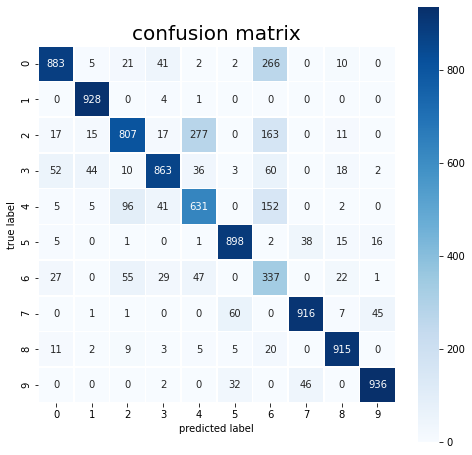

In [13]:
lr1 = LogisticRegression()
time_lr1, num_params_lr1 = train_lr_model(lr1,'n') # no regularization
accuracy_trainset_lr1, accuracy_testset_lr1 = test_model(lr1)

[1,  2000] loss: 1.696851
[1,  4000] loss: 1.640196
[1,  6000] loss: 1.630570
[1,  8000] loss: 1.620586
[1, 10000] loss: 1.614236
[1, 12000] loss: 1.606547
[1, 14000] loss: 1.610367
[2,  2000] loss: 1.601927
[2,  4000] loss: 1.598670
[2,  6000] loss: 1.597819
[2,  8000] loss: 1.592956
[2, 10000] loss: 1.594986
[2, 12000] loss: 1.589359
[2, 14000] loss: 1.594736
[3,  2000] loss: 1.590982
[3,  4000] loss: 1.591939
[3,  6000] loss: 1.591380
[3,  8000] loss: 1.587872
[3, 10000] loss: 1.590786
[3, 12000] loss: 1.586833
[3, 14000] loss: 1.588244
[4,  2000] loss: 1.590796
[4,  4000] loss: 1.584340
[4,  6000] loss: 1.584683
[4,  8000] loss: 1.585786
[4, 10000] loss: 1.582735
[4, 12000] loss: 1.583320
[4, 14000] loss: 1.584770
[5,  2000] loss: 1.585399
[5,  4000] loss: 1.581139
[5,  6000] loss: 1.583284
[5,  8000] loss: 1.582799
[5, 10000] loss: 1.581991
[5, 12000] loss: 1.580391
[5, 14000] loss: 1.582652
[6,  2000] loss: 1.580584
[6,  4000] loss: 1.578283
[6,  6000] loss: 1.580034
[6,  8000] l

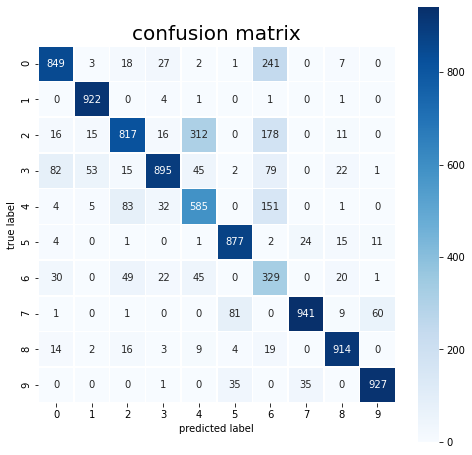

In [14]:
lr2 = LogisticRegression()
time_lr2, num_params_lr2 = train_lr_model(lr2, 'l1') # l1_regularization
accuracy_trainset_lr2, accuracy_testset_lr2 = test_model(lr2)

[1,  2000] loss: 1.786541
[1,  4000] loss: 1.755394
[1,  6000] loss: 1.762264
[1,  8000] loss: 1.756663
[1, 10000] loss: 1.756673
[1, 12000] loss: 1.757675
[1, 14000] loss: 1.755800
[2,  2000] loss: 1.756660
[2,  4000] loss: 1.754439
[2,  6000] loss: 1.764894
[2,  8000] loss: 1.758779
[2, 10000] loss: 1.756961
[2, 12000] loss: 1.754372
[2, 14000] loss: 1.758956
[3,  2000] loss: 1.757931
[3,  4000] loss: 1.752247
[3,  6000] loss: 1.762264
[3,  8000] loss: 1.758226
[3, 10000] loss: 1.759561
[3, 12000] loss: 1.757018
[3, 14000] loss: 1.757214
[4,  2000] loss: 1.758556
[4,  4000] loss: 1.753116
[4,  6000] loss: 1.762063
[4,  8000] loss: 1.758180
[4, 10000] loss: 1.756092
[4, 12000] loss: 1.752728
[4, 14000] loss: 1.756984
[5,  2000] loss: 1.755882
[5,  4000] loss: 1.754791
[5,  6000] loss: 1.761976
[5,  8000] loss: 1.757908
[5, 10000] loss: 1.756938
[5, 12000] loss: 1.754930
[5, 14000] loss: 1.757773
[6,  2000] loss: 1.759494
[6,  4000] loss: 1.754842
[6,  6000] loss: 1.758465
[6,  8000] l

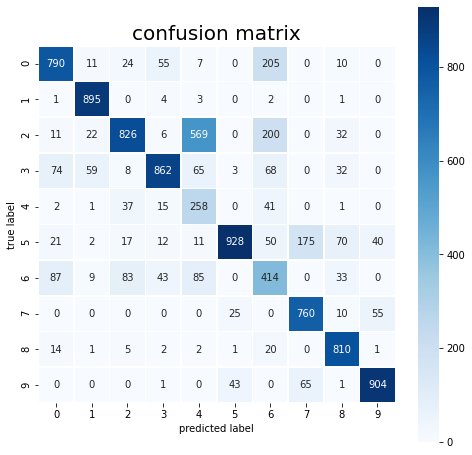

In [15]:
lr3 = LogisticRegression()
time_lr3, num_params_lr3 = train_lr_model(lr3,'l2') # l2_regularization
accuracy_trainset_lr3, accuracy_testset_lr3 = test_model(lr3)

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

myCNN = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN.parameters(), lr=0.01, momentum=0.5)

In [17]:
def train_cnn(model):
    max_epochs=6
    start=time.time()
    for epoch in range(max_epochs):  # loop over the dataset multiple times

        optimizer.zero_grad()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    end = time.time()
    print('Finished Training!')
    print('training time %.2f' % (end-start))
    num_params = sum(x.numel() for x in model.parameters())
    print("Total number of paramerters in cnn is {}".format(num_params))
    return (end-start), num_params

[1,  2000] loss: 0.912
[1,  4000] loss: 0.569
[1,  6000] loss: 0.483
[1,  8000] loss: 0.436
[1, 10000] loss: 0.414
[1, 12000] loss: 0.404
[1, 14000] loss: 0.388
[2,  2000] loss: 0.364
[2,  4000] loss: 0.361
[2,  6000] loss: 0.354
[2,  8000] loss: 0.340
[2, 10000] loss: 0.333
[2, 12000] loss: 0.333
[2, 14000] loss: 0.330
[3,  2000] loss: 0.318
[3,  4000] loss: 0.318
[3,  6000] loss: 0.316
[3,  8000] loss: 0.306
[3, 10000] loss: 0.304
[3, 12000] loss: 0.306
[3, 14000] loss: 0.303
[4,  2000] loss: 0.294
[4,  4000] loss: 0.291
[4,  6000] loss: 0.294
[4,  8000] loss: 0.285
[4, 10000] loss: 0.286
[4, 12000] loss: 0.289
[4, 14000] loss: 0.286
[5,  2000] loss: 0.280
[5,  4000] loss: 0.277
[5,  6000] loss: 0.283
[5,  8000] loss: 0.272
[5, 10000] loss: 0.269
[5, 12000] loss: 0.274
[5, 14000] loss: 0.275
[6,  2000] loss: 0.263
[6,  4000] loss: 0.267
[6,  6000] loss: 0.271
[6,  8000] loss: 0.264
[6, 10000] loss: 0.267
[6, 12000] loss: 0.263
[6, 14000] loss: 0.267
Finished Training!
training time 2

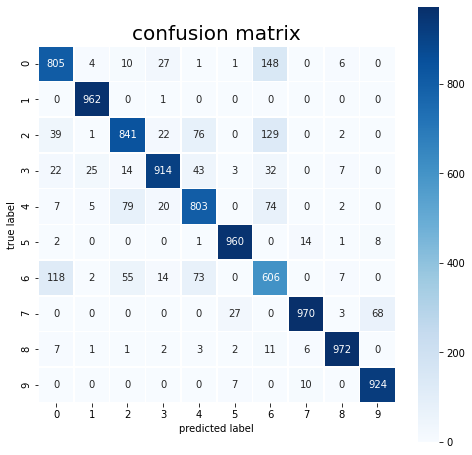

In [18]:
time_cnn1, num_params_cnn1 = train_cnn(myCNN)
accuracy_trainset_cnn1, accuracy_testset_cnn1 = test_model(myCNN)

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(320, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 40)
        self.fc4 = nn.Linear(40, 20)
        self.fc5 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

myCNN2 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN2.parameters(), lr=0.01, momentum=0.5)

In [20]:
time_cnn2, num_params_cnn2 = train_cnn(myCNN2)

[1,  2000] loss: 1.922
[1,  4000] loss: 0.807
[1,  6000] loss: 0.618
[1,  8000] loss: 0.525
[1, 10000] loss: 0.479
[1, 12000] loss: 0.450
[1, 14000] loss: 0.429
[2,  2000] loss: 0.403
[2,  4000] loss: 0.391
[2,  6000] loss: 0.378
[2,  8000] loss: 0.362
[2, 10000] loss: 0.349
[2, 12000] loss: 0.360
[2, 14000] loss: 0.344
[3,  2000] loss: 0.329
[3,  4000] loss: 0.329
[3,  6000] loss: 0.321
[3,  8000] loss: 0.317
[3, 10000] loss: 0.309
[3, 12000] loss: 0.309
[3, 14000] loss: 0.309
[4,  2000] loss: 0.296
[4,  4000] loss: 0.299
[4,  6000] loss: 0.292
[4,  8000] loss: 0.283
[4, 10000] loss: 0.281
[4, 12000] loss: 0.286
[4, 14000] loss: 0.286
[5,  2000] loss: 0.272
[5,  4000] loss: 0.274
[5,  6000] loss: 0.274
[5,  8000] loss: 0.263
[5, 10000] loss: 0.273
[5, 12000] loss: 0.264
[5, 14000] loss: 0.269
[6,  2000] loss: 0.255
[6,  4000] loss: 0.253
[6,  6000] loss: 0.256
[6,  8000] loss: 0.252
[6, 10000] loss: 0.250
[6, 12000] loss: 0.247
[6, 14000] loss: 0.253
Finished Training!
training time 3

accuracy of the model on training dataset 90.71
accuracy of the model on test dataset 88.51


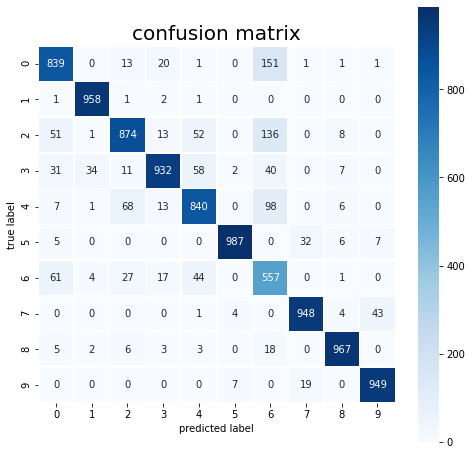

In [21]:
accuracy_trainset_cnn2, accuracy_testset_cnn2 = test_model(myCNN2)

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.conv3 = nn.Conv2d(10,15, 5)
        self.conv4 = nn.Conv2d(15,20, 5)
        self.conv5 = nn.Conv2d(20,25, 5)
        self.fc1 = nn.Linear(25*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 25*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

myCNN3 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN3.parameters(), lr=0.01, momentum=0.5)

In [23]:
time_cnn3, num_params_cnn3 = train_cnn(myCNN3)

[1,  2000] loss: 1.423
[1,  4000] loss: 0.772
[1,  6000] loss: 0.674
[1,  8000] loss: 0.600
[1, 10000] loss: 0.551
[1, 12000] loss: 0.527
[1, 14000] loss: 0.504
[2,  2000] loss: 0.461
[2,  4000] loss: 0.457
[2,  6000] loss: 0.447
[2,  8000] loss: 0.436
[2, 10000] loss: 0.411
[2, 12000] loss: 0.420
[2, 14000] loss: 0.413
[3,  2000] loss: 0.393
[3,  4000] loss: 0.393
[3,  6000] loss: 0.396
[3,  8000] loss: 0.392
[3, 10000] loss: 0.373
[3, 12000] loss: 0.388
[3, 14000] loss: 0.378
[4,  2000] loss: 0.361
[4,  4000] loss: 0.361
[4,  6000] loss: 0.370
[4,  8000] loss: 0.362
[4, 10000] loss: 0.346
[4, 12000] loss: 0.353
[4, 14000] loss: 0.352
[5,  2000] loss: 0.339
[5,  4000] loss: 0.340
[5,  6000] loss: 0.357
[5,  8000] loss: 0.338
[5, 10000] loss: 0.330
[5, 12000] loss: 0.339
[5, 14000] loss: 0.339
[6,  2000] loss: 0.331
[6,  4000] loss: 0.334
[6,  6000] loss: 0.354
[6,  8000] loss: 0.328
[6, 10000] loss: 0.321
[6, 12000] loss: 0.330
[6, 14000] loss: 0.342
Finished Training!
training time 6

accuracy of the model on training dataset 88.22
accuracy of the model on test dataset 86.72


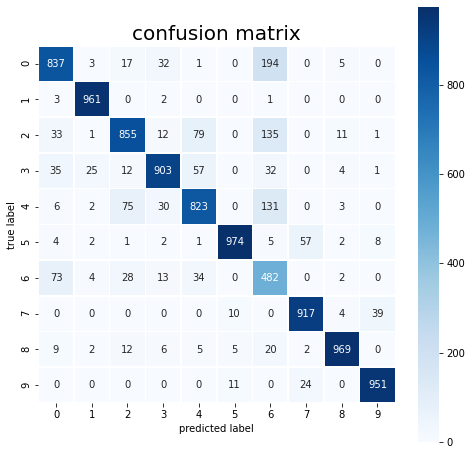

In [24]:
accuracy_trainset_cnn3, accuracy_testset_cnn3 = test_model(myCNN3)

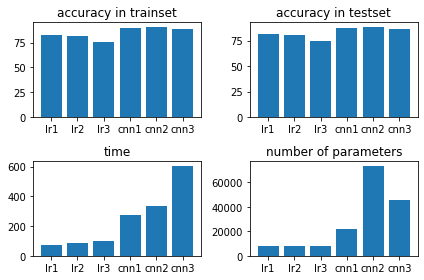

In [82]:
name_list = ['lr1', 'lr2', 'lr3', 'cnn1', 'cnn2', 'cnn3']
time_list = [time_lr1, time_lr2, time_lr3, time_cnn1, time_cnn2, time_cnn3]
params_list = [num_params_lr1, num_params_lr2, num_params_lr3, num_params_cnn1, num_params_cnn2, num_params_cnn3]
accuracy_trainset_list = [accuracy_trainset_lr1, accuracy_trainset_lr2, accuracy_trainset_lr3,
                         accuracy_trainset_cnn1, accuracy_trainset_cnn2, accuracy_trainset_cnn3]
accuracy_testset_list = [accuracy_testset_lr1, accuracy_testset_lr2, accuracy_testset_lr3, accuracy_testset_cnn1,
                        accuracy_testset_cnn2, accuracy_testset_cnn3]

fig=plt.figure()
ax1 = fig.add_subplot(221)
ax1.bar(range(len(accuracy_trainset_list)), accuracy_trainset_list, tick_label=name_list)
ax1.set_title('accuracy in trainset')

ax2 = fig.add_subplot(222)
ax2.bar(range(len(accuracy_testset_list)), accuracy_testset_list, tick_label = name_list)
ax2.set_title('accuracy in testset')

ax3 = fig.add_subplot(223)
ax3.bar(range(len(time_list)), time_list, tick_label = name_list)
ax3.set_title('time')

ax4 = fig.add_subplot(224)
ax4.bar(range(len(params_list)), params_list, tick_label = name_list)
ax4.set_title('number of parameters')

fig.tight_layout()